# Quantics TCI of univariate function


In [1]:
import sys
import numpy as np
from math import cos,sin,exp, sqrt, log, atan
import matplotlib.pyplot as plt
sys.path.append("../../build/python")  # set to correct path for module
import xfacpy

## Example 1

The first example is taken from Fig. 1 in [Ritter2024](https://arxiv.org/abs/2303.11819).

$$
f(x) = \cos\left(\frac{x}{B}\right) \cos\left(\frac{x}{4\sqrt{5}B}\right) e^{-x^2} + 2e^{-x},
$$

where $B = 2^{-30}$. In python, this can be written as below:


In [2]:
B = 2**(-30) # global variable
def f(x):
    return cos(x / B) * cos(x / (4 * sqrt(5) * B)) * exp(-x**2) + 2 * exp(-x)

def fcaching(x): # this is just to plot later the sampled points
    y = f(x)
    fcaching.sampled[x] = y    
    return y
fcaching.sampled = {}          # this is just to plot later the sampled points

print(f(0.2))

1.7990930849034745


Let's examine the behaviour of $f(x)$. This function involves structure on widely different scales: rapid, incommensurate oscillations and a slowly decaying envelope.
For small $x$ we have:

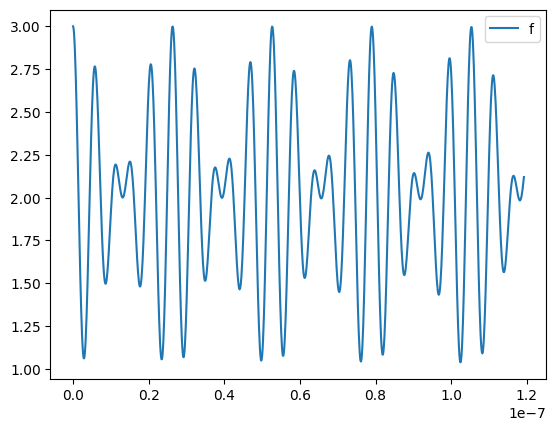

In [3]:
xs = np.linspace(0, 2.0**(-23), 1000)
ys = [f(x) for x in xs]
fig, ax = plt.subplots()
ax.plot(xs, ys, label="f")
ax.legend()

For $x \in (0, 3]$ we will get:


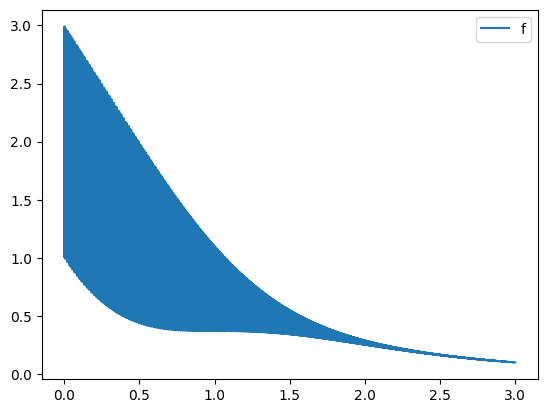

In [4]:
xs = np.linspace(2.0**(-23), 3, 100000)
ys = [f(x) for x in xs]
fig, ax = plt.subplots()
ax.plot(xs, ys, label="f")
ax.legend()

### QTT representation

A quantics grid is an uniform grid with $2^R$ points in [a,b):

$x_i=a+i\Delta$,

where $\Delta = (b -a)/2^R $ and $i=0,1,...,2^R-1 $.

The function $f$ is mapped to a tensor with $R$ legs in the following way. The binary digits $\{\sigma_i\}$ of $i$ are used as indices of the tensor $F$ defined by:
$$
F(\{\sigma_i\})=f(x_i)
$$


Let's construct a QTT representation of our $f$ on the domain $[0,3)$ using $2^{40}$ points.

In [5]:
qgrid = xfacpy.QuanticsGrid(a=0.0, b=3.0, nBit=40)  # build the quantics grid
args = xfacpy.TensorCI2Param()                      # fix the max bond dimension
args.bondDim = 15
ci = xfacpy.QTensorCI(f1d=fcaching, qgrid=qgrid, args=args)  # construct a tci of the quantics tensor
while not ci.isDone():
    ci.iterate()

### Check the convergence
Here, we've created the object `ci` which is both a `QTensorCI` and a `TensorCI2`.
The first thing to check is the convergence, ie, how the pivot error decrease.

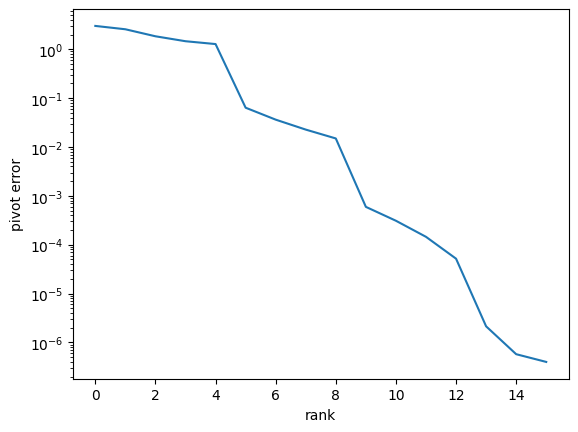

In [6]:
plt.xlabel("rank")
plt.ylabel("pivot error")
plt.yscale("log")
plt.plot(ci.pivotError);

### Plotting the approximation
Let's get the approximated function `qtt`. It can be saved/loaded to a hard disc, evaluated, and plotted:

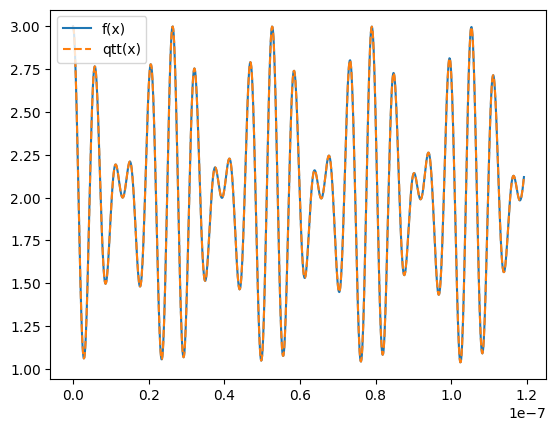

In [7]:
qtt=ci.get_qtt()    ## the actual function approximating f
xs = np.linspace(0, 2.0**(-23), 1000)
fs=[f(x) for x in xs]
tts=[qtt.eval([x]) for x in xs]

plt.plot(xs,fs, '-', label=f'f(x)')
plt.plot(xs,tts,'--', label=f'qtt(x)')
plt.legend();

Above, one can see that the original function is interpolated very accurately.

Let's plot of $x$ vs interpolation error $\log(|f(x) - \mathrm{ci}(x)|)$ for small $x$


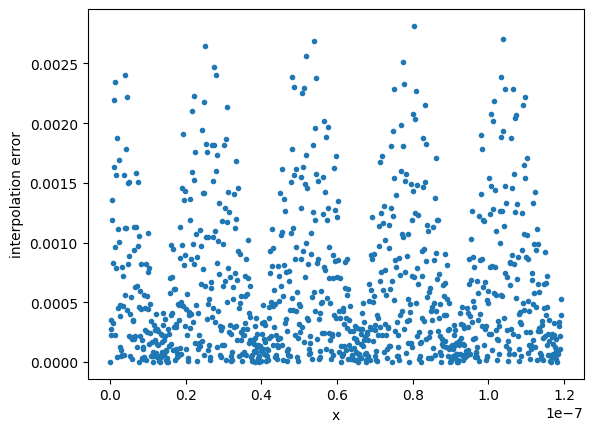

In [8]:
plt.plot(xs,[abs(a - b) for a, b in zip(fs, tts)], '.', label=f'f(x')
plt.xlabel("x")
plt.ylabel("interpolation error");

### Function evaluations

Our TCI algorithm does not call elements of the entire tensor, but constructs the TT (Tensor Train) from some elements chosen adaptively. On which points $x \in [0, 3]$ was the function evaluated to construct a QTT representation of the function $f(x)$? Let's plot f and the evaluated points together.

7982 sampled points


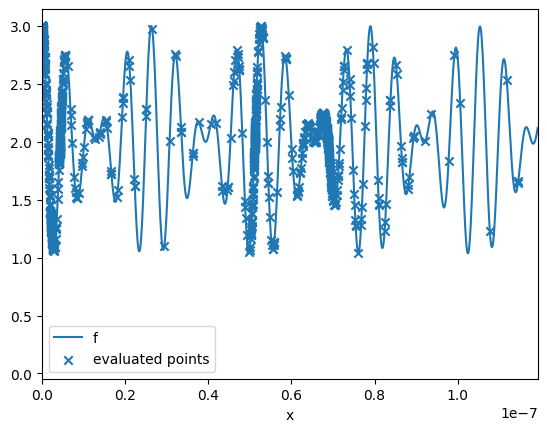

In [9]:
xs_evaluated = [x for x,y in fcaching.sampled.items()] 
fs_evaluated = [y for x,y in fcaching.sampled.items()]

plt.plot(xs, fs, label="f")
plt.scatter(xs_evaluated, fs_evaluated, marker="x", label="evaluated points")
plt.xlabel("x")
plt.xlim(0, max(xs))
plt.legend();
print(f'{len(fcaching.sampled)} sampled points')

## Example 2

We now consider the function:

$$
f(x) = \mathrm{sinc}(x)+3e^{-0.3(x-4)^2}\mathrm{sinc}(x-4) - \cos(4x)^2-2\mathrm{sinc}(x+10)e^{-0.6(x+9)} + 4 \cos(2x) e^{-|x+5|} + \frac{6}{x-11}+ \sqrt{(|x|)}\arctan(x/15)
$$

One can construct a QTT representation of this function on the domain $[-10, 10]$ using a quantics grid of size $2^\mathcal{R}$ ($\mathcal{R}=20$):


In [10]:
qgrid = xfacpy.QuanticsGrid(a=-10, b=10, nBit=20)  # build the quantics grid

# Function of interest
def f(x):
    return (
        np.sinc(x) + 3 * exp(-0.3 * (x - 4)**2) * np.sinc(x - 4) - cos(4 * x)**2 -
        2 * np.sinc(x + 10) * exp(-0.6 * (x + 9)) + 4 * cos(2 * x) * exp(-abs(x + 5)) +
        6 * 1 / (x - 11) + sqrt(abs(x)) * atan(x / 15))

args = xfacpy.TensorCI2Param()                      # fix the max bond dimension
args.bondDim = 15
ci = xfacpy.QTensorCI(f1d=f, qgrid=qgrid, args=args)  # construct a tci of the quantics tensor
while not ci.isDone():
    ci.iterate()

### Plot the convergence of the pivot error

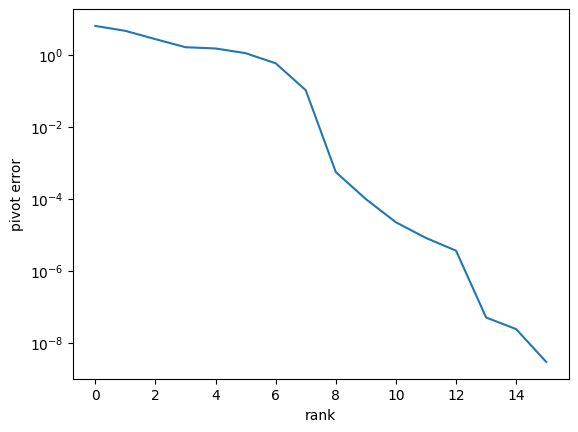

In [11]:
plt.xlabel("rank")
plt.ylabel("pivot error")
plt.yscale("log")
plt.plot(ci.pivotError);

### Plot the actual approximation of the function

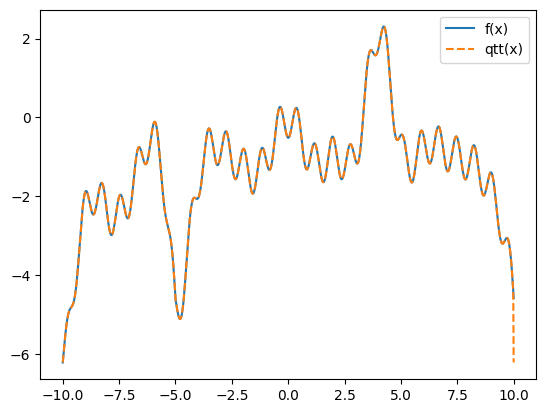

In [12]:
qtt=ci.get_qtt()    ## the actual function approximating f
xs = np.linspace(-10,10, 1000)
fs=[f(x) for x in xs]
tts=[qtt.eval([x]) for x in xs]

plt.plot(xs,fs, '-', label=f'f(x)')
plt.plot(xs,tts,'--', label=f'qtt(x)')
plt.legend();